In [ ]:
# from src.mcp_server import save_question

# qid = "Q_test1234"
# result = save_question(qid, "C123", "Nhà hàng nào bán bún chả?")
# print(result)

# 📘 Text → Knowledge Graph (Việt Nam Restaurant Domain)

Pipeline demo: Từ 1 đoạn văn bản tiếng Việt mô tả hành vi/thói quen khách hàng → trích xuất thực thể & quan hệ → ghi vào Neo4j.

Sections:
1. Cấu hình & Thư viện
2. Kết nối Neo4j
3. Đoạn văn bản nguồn
4. Tiền xử lý & Tách câu
5. NER underthesea
6. Từ khóa miền (món ăn, khẩu vị, thời gian)
7. Chuẩn hóa & Ánh xạ schema
8. Sinh quan hệ rule-based
9. Loại trùng & payload
10. Sinh Cypher động
11. Ghi dữ liệu
12. Tạo constraint còn thiếu
13. Truy vấn kiểm tra
14. Mini visualization
15. Pipeline tổng hợp
16. Test đoạn text khác
17. Log & debug


In [57]:
# SECTION 1: Cấu hình & Thư viện (Install + Import)
import sys, subprocess, importlib, logging, math, json, re, unicodedata, time
from pathlib import Path

REQUIRED = ["neo4j", "underthesea", "python-dotenv", "networkx", "matplotlib"]
for pkg in REQUIRED:
    try:
        importlib.import_module(pkg.split('==')[0])
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

from neo4j import GraphDatabase
from underthesea import ner, sent_tokenize, word_tokenize
import networkx as nx
import matplotlib.pyplot as plt
from dataclasses import dataclass

logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s %(message)s')
logger = logging.getLogger("text_to_graph")

@dataclass
class Config:
    uri: str = "bolt://localhost:7687"
    user: str = "neo4j"
    password: str = "12345678"
    database: str = "neo4j"

CFG = Config()
logger.info("Libraries imported & config initialized")

Installing python-dotenv ...


[2025-09-22 16:36:43,070] INFO Libraries imported & config initialized


In [58]:
# SECTION 2: Thiết lập Kết nối Neo4j (Driver & Test Ping)
from contextlib import contextmanager

driver = GraphDatabase.driver(CFG.uri, auth=(CFG.user, CFG.password))

@contextmanager
def neo4j_session(database: str = CFG.database):
    sess = driver.session(database=database)
    try:
        yield sess
    finally:
        sess.close()

with neo4j_session() as s:
    ver = s.run("CALL dbms.components() YIELD name, versions RETURN name, versions[0] AS version LIMIT 1").data()
    test = s.run("RETURN 1 AS ok").single()["ok"]
    logger.info(f"Neo4j version: {ver[0]['version']} | test={test}")

[2025-09-22 16:36:43,160] INFO Neo4j version: 5.26.8 | test=1


In [59]:
# SECTION 3: Định nghĩa Đoạn Văn Bản Nguồn (1 đoạn text mẫu)
raw_text = (
    "Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm. "
    "Anh ấy thường đi ăn vào khoảng 18:00-20:30 tối Thứ Hai và đôi khi chọn thêm món có hương vị Khô để cân bằng."
)
print(raw_text)

Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm. Anh ấy thường đi ăn vào khoảng 18:00-20:30 tối Thứ Hai và đôi khi chọn thêm món có hương vị Khô để cân bằng.


In [60]:
# SECTION 4: Tiền Xử Lý & Tách Câu

def normalize_text(txt: str) -> str:
    txt = unicodedata.normalize('NFC', txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def split_sentences(txt: str):
    txt = normalize_text(txt)
    # underthesea sent_tokenize đôi khi tách chưa chuẩn với câu ngắn => fallback simple split
    try:
        sents = sent_tokenize(txt)
    except Exception:
        sents = re.split(r"(?<=[.!?])\s+", txt)
    return [s.strip() for s in sents if s.strip()]

sentences = split_sentences(raw_text)
for i, s in enumerate(sentences):
    print(f"Sentence {i}: {s}")

Sentence 0: Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.
Sentence 1: Anh ấy thường đi ăn vào khoảng 18:00-20:30 tối Thứ Hai và đôi khi chọn thêm món có hương vị Khô để cân bằng.


In [61]:
# SECTION 5: Nhận Diện Thực Thể (NER with underthesea)
# underthesea.ner đôi khi thay đổi format tuple giữa các phiên bản.
# Ta viết hàm parser linh hoạt để tránh lỗi unpack.

def parse_span(span, sentence):
    """Return (form,pos,label,start,end) with graceful fallbacks."""
    form = pos = label = None
    start = end = None
    if isinstance(span, (list, tuple)):
        ln = len(span)
        # Các khả năng thường gặp:
        # (form, pos, label)
        # (form, pos, label, start)
        # (form, pos, label, start, end)
        if ln == 5:
            form, pos, label, start, end = span
        elif ln == 4:
            form, pos, label, start = span
            end = start + len(form) if isinstance(start, int) else None
        elif ln == 3:
            form, pos, label = span
            # tìm vị trí đầu tiên (best effort)
            try:
                start = sentence.index(form)
                end = start + len(form)
            except ValueError:
                start = end = None
        else:
            return None
    else:
        return None
    return form, pos, label, start, end


def run_ner(sent_list):
    results = []
    for sid, sent in enumerate(sent_list):
        try:
            spans = ner(sent)
        except Exception as e:
            logger.warning(f"NER fail sentence {sid}: {e}")
            spans = []
        if spans and sid == 0:
            logger.info(f"Sample raw NER span[0]: {spans[0]}")
        for span in spans:
            parsed = parse_span(span, sent)
            if not parsed:
                continue
            form, pos, r, start, end = parsed
            if r and r != 'O':
                results.append({
                    'text': form,
                    'label': r,
                    'start': start,
                    'end': end,
                    'sent_id': sid,
                    'sentence': sent
                })
    return results

ner_entities = run_ner(sentences)
print("NER entities:")
for e in ner_entities:
    print(e)

[2025-09-22 16:36:43,185] INFO Sample raw NER span[0]: ('Khách hàng', 'N', 'B-NP', 'O')


NER entities:
{'text': 'Khách hàng', 'label': 'B-NP', 'start': 'O', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.'}
{'text': 'Nguyễn Văn A', 'label': 'B-NP', 'start': 'B-PER', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.'}
{'text': 'thích', 'label': 'B-VP', 'start': 'O', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.'}
{'text': 'các', 'label': 'B-NP', 'start': 'O', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.'}
{'text': 'món', 'label': 'B-NP', 'start': 'B-LOC', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất thích các món Khô, đặc biệt là Bánh xèo giòn thơm.'}
{'text': 'Khô', 'label': 'B-NP', 'start': 'I-LOC', 'end': None, 'sent_id': 0, 'sentence': 'Khách hàng Nguyễn Văn A rất t

In [62]:
# SECTION 6: Rút Trích Thuộc Tính & Từ Khóa Miền
# Tạm thời dùng từ điển cứng; có thể mở rộng bằng truy vấn Neo4j để lấy danh sách thực tế.
DOMAIN_DISHES = {"bánh xèo": "Dish"}
DOMAIN_TAGS = {"đồ béo": "Tag", "nhạt": "Tag"}
TIME_SLOT_PATTERN = re.compile(r"\b(\d{2}:\d{2}-\d{2}:\d{2})\b")
DAY_MAP = {"thứ hai": "Mon", "thứ ba": "Tue", "thứ tư": "Wed", "thứ năm": "Thu", "thứ sáu": "Fri", "thứ bảy": "Sat", "chủ nhật": "Sun"}

# Simple token scan (lowercase)
text_lower = raw_text.lower()
found_dishes = [d for d in DOMAIN_DISHES if d in text_lower]
found_tags = [t for t in DOMAIN_TAGS if t in text_lower]
found_slots = TIME_SLOT_PATTERN.findall(raw_text)
found_days = [DAY_MAP[k] for k in DAY_MAP if k in text_lower]

print("Dishes:", found_dishes)
print("Tags:", found_tags)
print("TimeSlots:", found_slots)
print("Days:", found_days)

Dishes: ['bánh xèo']
Tags: []
TimeSlots: ['18:00-20:30']
Days: ['Mon']


In [63]:
# SECTION 7: Chuẩn Hóa & Ánh Xạ Thực Thể → Schema

def normalize_entity(text: str):
    t = text.strip()
    t = re.sub(r"[""'“”‘’,;:.!?]", "", t)
    return t[:1].upper() + t[1:] if t else t

nodes_collected = []
# Customer implicit 1 khách => tạo 1 node Customer với full_name nếu có entity PER
customer_name = None
for e in ner_entities:
    if e['label'] == 'PER' and len(e['text'].split()) >= 2:
        customer_name = normalize_entity(e['text'])
        break
if customer_name:
    nodes_collected.append({'label': 'Customer', 'key': 'full_name', 'value': customer_name})

for d in found_dishes:
    nodes_collected.append({'label': 'Dish', 'key': 'name_of_food', 'value': normalize_entity(d)})
for t in found_tags:
    nodes_collected.append({'label': 'Tag', 'key': 'tag', 'value': normalize_entity(t)})
for slot in found_slots:
    nodes_collected.append({'label': 'TimeSlot', 'key': 'slot', 'value': slot})
for day in found_days:
    nodes_collected.append({'label': 'DayOfWeek', 'key': 'day', 'value': day})

print("Nodes collected (raw):")
for n in nodes_collected:
    print(n)

Nodes collected (raw):
{'label': 'Dish', 'key': 'name_of_food', 'value': 'Bánh xèo'}
{'label': 'TimeSlot', 'key': 'slot', 'value': '18:00-20:30'}
{'label': 'DayOfWeek', 'key': 'day', 'value': 'Mon'}


In [64]:
# SECTION 8: Sinh Quan Hệ Tiềm Năng (rule-based)
relationships_raw = []

# Patterns đơn giản dựa trên từ khóa trong text
if customer_name:
    if found_tags:
        for t in found_tags:
            relationships_raw.append({
                'start': ('Customer', 'full_name', customer_name),
                'type': 'FOLLOWS',
                'end': ('Tag', 'tag', normalize_entity(t)),
                'props': {}
            })
    if found_dishes:
        # tạo Bill giả lập trong phạm vi đoạn text? Đơn giản: liên kết trực tiếp Customer→Dish bằng PREFERS
        for d in found_dishes:
            relationships_raw.append({
                'start': ('Customer', 'full_name', customer_name),
                'type': 'PREFERS_DISH',
                'end': ('Dish', 'name_of_food', normalize_entity(d)),
                'props': {}
            })
    if found_slots:
        for slot in found_slots:
            relationships_raw.append({
                'start': ('Customer', 'full_name', customer_name),
                'type': 'HABIT_AT',
                'end': ('TimeSlot', 'slot', slot),
                'props': {}
            })
    if found_days:
        for day in found_days:
            relationships_raw.append({
                'start': ('Customer', 'full_name', customer_name),
                'type': 'HABIT_ON',
                'end': ('DayOfWeek', 'day', day),
                'props': {}
            })

print("Relationships raw:")
for r in relationships_raw:
    print(r)

Relationships raw:


In [65]:
# SECTION 9: Loại Bỏ Trùng Lặp & Tạo Payload Upsert

def deduplicate_nodes(nodes):
    seen = {}
    for n in nodes:
        k = (n['label'], n['key'], n['value'])
        if k not in seen:
            seen[k] = n
    return list(seen.values())

def build_payload(nodes, rels):
    nodes_dedup = deduplicate_nodes(nodes)
    rels_dedup = []
    seen_rel = set()
    for r in rels:
        key = (r['start'], r['type'], r['end'])
        if key not in seen_rel:
            seen_rel.add(key)
            rels_dedup.append(r)
    return nodes_dedup, rels_dedup

nodes_payload, rels_payload = build_payload(nodes_collected, relationships_raw)
print("Nodes payload:")
print(nodes_payload)
print("Rels payload:")
print(rels_payload)

Nodes payload:
[{'label': 'Dish', 'key': 'name_of_food', 'value': 'Bánh xèo'}, {'label': 'TimeSlot', 'key': 'slot', 'value': '18:00-20:30'}, {'label': 'DayOfWeek', 'key': 'day', 'value': 'Mon'}]
Rels payload:
[]


In [66]:
# SECTION 10: Sinh Cypher Động (UNWIND + MERGE patterns)

NODE_KEY_MAP = {
    'Customer': 'full_name',
    'Dish': 'name_of_food',
    'Tag': 'tag',
    'TimeSlot': 'slot',
    'DayOfWeek': 'day'
}

MERGE_NODE_SNIPPET = {
    label: f"MERGE (n:{label} {{{key}: node.value}})" for label, key in NODE_KEY_MAP.items()
}

REL_CLAUSES = {
    'FOLLOWS': 'CREATE UNIQUE (a)-[:FOLLOWS]->(b)',  # We'll adapt to MERGE below
}

CYTHER_TEMPLATE = """
UNWIND $nodes AS node
CALL {
  WITH node
  {node_merges}
  RETURN 0
}
UNWIND $rels AS rel
MATCH (s:{start_label} {{{start_key}: rel.start_value}})
MATCH (e:{end_label} {{{end_key}: rel.end_value}})
MERGE (s)-[r:{rel_type}]->(e)
SET r += rel.props
"""

# We'll build per relationship type dynamically at execution time rather than fully static multi label template.
print("Cypher dynamic builder ready.")

Cypher dynamic builder ready.


In [67]:
# SECTION 11: Ghi Dữ Liệu Lên Neo4j (rewrite: dùng FOREACH tránh subquery WITH + WHERE lỗi)
# Nguyên nhân lỗi trước: nhiều CALL { WITH node WHERE ... } tuần tự; Neo4j hạn chế WITH import + WHERE dạng này.
# Cách mới: UNWIND và dùng FOREACH + CASE để điều kiện hoá MERGE theo label, tránh xung đột biến / hạn chế cú pháp.

LABEL_KEY = {
    'Customer': 'full_name',
    'Dish': 'name_of_food',
    'Tag': 'tag',
    'TimeSlot': 'slot',
    'DayOfWeek': 'day'
}

REL_MATCH = {
    'FOLLOWS':   ('Customer','full_name','Tag','tag','FOLLOWS'),
    'PREFERS_DISH': ('Customer','full_name','Dish','name_of_food','PREFERS_DISH'),
    'HABIT_AT':  ('Customer','full_name','TimeSlot','slot','HABIT_AT'),
    'HABIT_ON':  ('Customer','full_name','DayOfWeek','day','HABIT_ON')
}

from collections import defaultdict

def build_node_query(labels_present):
    parts = ["UNWIND $nodes AS node"]
    for label in sorted(labels_present):
        key = LABEL_KEY[label]
        parts.append(
            f"FOREACH (_ IN CASE WHEN node.label='{label}' THEN [1] ELSE [] END | MERGE (: {label} {{{key}: node.value}}))".replace(': ', ':')
        )
    return "\n".join(parts)

def build_rel_query(rel_types_present):
    parts = ["UNWIND $rels AS rel"]
    for rtype in sorted(rel_types_present):
        if rtype not in REL_MATCH:
            continue
        sl, sk, el, ek, cypher_type = REL_MATCH[rtype]
        parts.append(
            (
                "FOREACH (_ IN CASE WHEN rel.type='" + rtype + "' THEN [1] ELSE [] END | "
                f"MATCH (s:{sl} {{{sk}: rel.start_value}}) "
                f"MATCH (e:{el} {{{ek}: rel.end_value}}) "
                f"MERGE (s)-[r:{cypher_type}]->(e) SET r += rel.props )"
            )
        )
    return "\n".join(parts)


def write_graph(nodes_payload, rels_payload):
    if not nodes_payload and not rels_payload:
        logger.info("Nothing to write")
        return {'nodes_written':0,'rels_written':0}

    node_params = [
        {'label': n['label'], 'key': n['key'], 'value': n['value']} for n in nodes_payload
    ]

    rel_params = []
    for r in rels_payload:
        (sl, sk, sv) = r['start']
        (el, ek, ev) = r['end']
        rel_params.append({
            'type': r['type'],
            'start_value': sv,
            'end_value': ev,
            'props': r['props']
        })

    labels_present = {n['label'] for n in nodes_payload}
    rel_types_present = {r['type'] for r in rel_params}

    node_query = build_node_query(labels_present) if labels_present else None
    rel_query  = build_rel_query(rel_types_present) if rel_types_present else None

    nodes_written = 0
    rels_written = 0
    with neo4j_session() as s:
        if node_query:
            summary_nodes = s.run(node_query, nodes=node_params).consume()
            c = summary_nodes.counters
            nodes_written = c.nodes_created + c.nodes_deleted + 0  # created only is fine
        if rel_query and rel_params:
            summary_rels = s.run(rel_query, rels=rel_params).consume()
            rels_written = summary_rels.counters.relationships_created

    logger.info(f"Write complete (approx): nodes_created={nodes_written} rels_created={rels_written}")
    return {'nodes_written': nodes_written, 'rels_written': rels_written}

# Chạy lại sau khi vá
write_stats = write_graph(nodes_payload, rels_payload)
write_stats

[2025-09-22 16:36:43,296] INFO Write complete (approx): nodes_created=0 rels_created=0


{'nodes_written': 0, 'rels_written': 0}

In [68]:
# SECTION 12: Tạo Index/Constraint Bổ Sung Nếu Thiếu
CONSTRAINTS = [
    ("Customer", "full_name"),
    ("Dish", "name_of_food"),
    ("Tag", "tag"),
    ("TimeSlot", "slot"),
    ("DayOfWeek", "day")
]

def ensure_constraints():
    with neo4j_session() as s:
        existing = s.run("SHOW CONSTRAINTS").data()
        exist_desc = [e.get('name','') + str(e) for e in existing]
        for label, prop in CONSTRAINTS:
            cypher = f"CREATE CONSTRAINT IF NOT EXISTS FOR (n:{label}) REQUIRE n.{prop} IS UNIQUE" \
                     if label != 'Customer' else f"CREATE CONSTRAINT IF NOT EXISTS FOR (n:{label}) REQUIRE n.{prop} IS UNIQUE"
            s.run(cypher)
    logger.info("Constraints ensured")

ensure_constraints()

[2025-09-22 16:36:43,312] INFO Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Customer) REQUIRE (e.full_name) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_eb58d84f FOR (e:Customer) REQUIRE (e.full_name) IS UNIQUE` already exists.} {position: None} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (n:Customer) REQUIRE n.full_name IS UNIQUE'
[2025-09-22 16:36:43,315] INFO Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Dish) REQUIRE (e.name_of_food) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_d759105d FOR (e:Dish) REQUIRE (e.name_of_food) IS UNIQUE` already exists.} {position: None} for query: 'CREATE CONSTRAINT IF NOT EXISTS FOR (n:Dish) REQUIRE n.nam

In [69]:
# SECTION 13: Truy Vấn Kiểm Tra Nhanh
with neo4j_session() as s:
    print("Customer – Tag:")
    for r in s.run("MATCH (c:Customer)-[:FOLLOWS]->(t:Tag) RETURN c.full_name AS customer, t.tag AS tag LIMIT 10"):
        print(r)
    print("Customer – TimeSlot:")
    for r in s.run("MATCH (c:Customer)-[:HABIT_AT]->(ts:TimeSlot) RETURN c.full_name, ts.slot"):
        print(r)
    print("Paths Customer -> Dish:")
    for r in s.run("MATCH p=(c:Customer)-[*1..2]->(d:Dish) RETURN p LIMIT 5"):
        print(r)

Customer – Tag:
<Record customer='Nguyễn Văn A' tag='Đồ béo'>
<Record customer='Trần Thị B' tag='Nhạt'>
Customer – TimeSlot:
<Record c.full_name='Nguyễn Văn A' ts.slot='18:00-20:30'>
Paths Customer -> Dish:
<Record p=<Path start=<Node element_id='4:89bba9a9-db0f-40e3-9890-220ba4e29882:0' labels=frozenset({'Customer'}) properties={'full_name': 'Nguyễn Văn A', 'gender': 'male', 'phone': '0901111222', 'dob': neo4j.time.Date(1990, 5, 10), 'customer_id': 'C001', 'email': 'a@mail.com'}> end=<Node element_id='4:89bba9a9-db0f-40e3-9890-220ba4e29882:2' labels=frozenset({'Dish'}) properties={'dish_id': 'D001', 'serves_max': 3, 'type_of_food': 'MÓN KHAI VỊ', 'taste': 'Đồ béo', 'how_to_prepare': 'Đổ bột gạo, nước cốt dừa, chiên giòn', 'serves_min': 2, 'current_price': 145000, 'name_of_food': 'Bánh xèo', 'outstanding_fragrance': 'Thơm nước cốt dừa'}> size=2>>
<Record p=<Path start=<Node element_id='4:89bba9a9-db0f-40e3-9890-220ba4e29882:0' labels=frozenset({'Customer'}) properties={'full_name': 'Ng

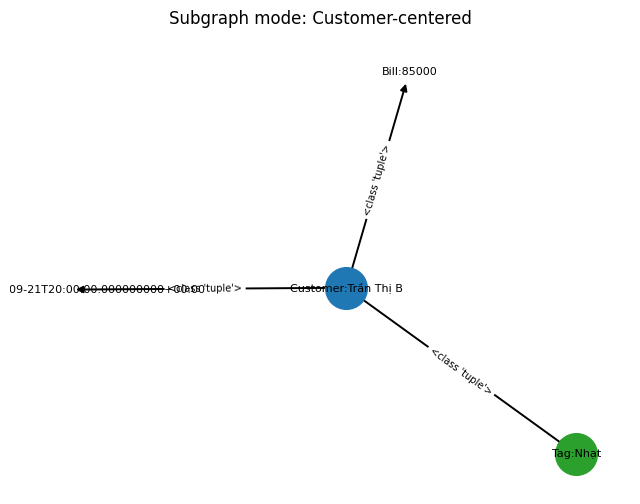

In [70]:
# SECTION 14: Mini Visualization (networkx) - improved + bugfix for dict without .labels
# Cải tiến:
# - Nếu customer_name không tồn tại, fallback dùng Customer gần đây
# - Nếu không có, hiển thị node/rel từ nodes_payload/rels_payload
# - Trả về labels() trực tiếp trong Cypher để tránh dùng thuộc tính .labels gây AttributeError
# - Hàm helper extract_ident để chọn thuộc tính hiển thị

COLOR_MAP = {
    'Customer': '#1f77b4',
    'Dish': '#ff7f0e',
    'Tag': '#2ca02c',
    'TimeSlot': '#9467bd',
    'DayOfWeek': '#8c564b'
}

DISPLAY_KEYS = ("name_of_food","tag","slot","day","full_name")

from typing import Tuple

def extract_ident(node_props: dict) -> Tuple[str,str]:
    """Return (label, value) best-effort. Caller already knows label externally.
    We just pick a value from DISPLAY_KEYS or first property."""
    for k in DISPLAY_KEYS:
        if k in node_props:
            return k, node_props[k]
    if node_props:
        k,v = next(iter(node_props.items()))
        return k,v
    return 'id','UNK'

active_customer = customer_name
if not active_customer:
    with neo4j_session() as s:
        row = s.run("MATCH (c:Customer) RETURN c.full_name AS name ORDER BY c.full_name DESC LIMIT 1").single()
        if row:
            active_customer = row["name"]

sub_nodes = []   # list[(label,value)]
sub_edges = []   # list[((label,val),(label,val),rel_type)]
query_run = None
with neo4j_session() as s:
    if active_customer:
        query_run = "Customer-centered"
        data = s.run(
            """
            MATCH (c:Customer {full_name:$name})-[r]->(x)
            RETURN c{.*} AS c_props, labels(c) AS c_labels, r, x{.*} AS x_props, labels(x) AS x_labels
            UNION
            MATCH (y)-[r2]->(c2:Customer {full_name:$name})
            RETURN c2{.*} AS c_props, labels(c2) AS c_labels, r2 AS r, y{.*} AS x_props, labels(y) AS x_labels
            """, name=active_customer
        ).data()
        for row in data:
            c_props = row['c_props']; x_props = row['x_props']; rel = row['r']
            c_label = row['c_labels'][0] if row['c_labels'] else 'Customer'
            x_label = row['x_labels'][0] if row['x_labels'] else 'Unknown'
            _, c_ident = extract_ident(c_props)
            _, x_ident = extract_ident(x_props)
            sub_nodes.append((c_label, c_ident))
            sub_nodes.append((x_label, x_ident))
            sub_edges.append(((c_label, c_ident),(x_label, x_ident), type(rel)))
    else:
        query_run = "Payload-centered"
        for n in nodes_payload:
            sub_nodes.append((n['label'], n['value']))
        for r in rels_payload:
            (sl, sk, sv) = r['start']
            (el, ek, ev) = r['end']
            sub_nodes.append((sl, sv))
            sub_nodes.append((el, ev))
            sub_edges.append(((sl, sv),(el, ev), r['type']))

# Xây graph
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
for lbl, val in set(sub_nodes):
    G.add_node(f"{lbl}:{val}", label=lbl)
for s_n, e_n, rel in sub_edges:
    s_key = f"{s_n[0]}:{s_n[1]}"; e_key = f"{e_n[0]}:{e_n[1]}"
    G.add_edge(s_key, e_key, rel=rel)

plt.figure(figsize=(8,6))
if len(G) == 0:
    plt.text(0.5,0.5,"Không có dữ liệu để hiển thị", ha='center', va='center', fontsize=14)
    plt.axis('off')
else:
    pos = nx.spring_layout(G, seed=42, k=0.8)
    for lbl in COLOR_MAP:
        nodes_lbl = [n for n,d in G.nodes(data=True) if d['label']==lbl]
        if nodes_lbl:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes_lbl, node_color=COLOR_MAP[lbl], node_size=900)
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', width=1.4)
    edge_labels = nx.get_edge_attributes(G, 'rel')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.axis('off')
plt.title(f'Subgraph mode: {query_run}')
plt.show()

In [71]:
# SECTION 15: Hàm Pipeline Tổng Hợp

def run_once(text: str):
    t0 = time.time()
    sents = split_sentences(text)
    ents = run_ner(sents)
    lower = text.lower()
    dishes = [d for d in DOMAIN_DISHES if d in lower]
    tags = [t for t in DOMAIN_TAGS if t in lower]
    slots = TIME_SLOT_PATTERN.findall(text)
    days = [DAY_MAP[k] for k in DAY_MAP if k in lower]
    # reuse normalization logic
    cust = None
    for e in ents:
        if e['label'] == 'PER' and len(e['text'].split()) >= 2:
            cust = normalize_entity(e['text']); break
    nodes_tmp = []
    if cust:
        nodes_tmp.append({'label': 'Customer', 'key': 'full_name', 'value': cust})
    for d in dishes:
        nodes_tmp.append({'label': 'Dish', 'key': 'name_of_food', 'value': normalize_entity(d)})
    for t in tags:
        nodes_tmp.append({'label': 'Tag', 'key': 'tag', 'value': normalize_entity(t)})
    for s in slots:
        nodes_tmp.append({'label': 'TimeSlot', 'key': 'slot', 'value': s})
    for d_ in days:
        nodes_tmp.append({'label': 'DayOfWeek', 'key': 'day', 'value': d_})
    rels_tmp = []
    if cust:
        for t in tags:
            rels_tmp.append({'start': ('Customer','full_name',cust), 'type': 'FOLLOWS', 'end': ('Tag','tag', normalize_entity(t)), 'props': {}})
        for d in dishes:
            rels_tmp.append({'start': ('Customer','full_name',cust), 'type': 'PREFERS_DISH', 'end': ('Dish','name_of_food', normalize_entity(d)), 'props': {}})
        for s in slots:
            rels_tmp.append({'start': ('Customer','full_name',cust), 'type': 'HABIT_AT', 'end': ('TimeSlot','slot', s), 'props': {}})
        for d_ in days:
            rels_tmp.append({'start': ('Customer','full_name',cust), 'type': 'HABIT_ON', 'end': ('DayOfWeek','day', d_), 'props': {}})
    nodes_p, rels_p = build_payload(nodes_tmp, rels_tmp)
    stats = write_graph(nodes_p, rels_p)
    dt = time.time() - t0
    return {
        'customer': cust,
        'nodes_detected': len(nodes_tmp),
        'nodes_written': stats.get('nodes_written'),
        'rels_written': stats.get('rels_written'),
        'elapsed_sec': round(dt, 3)
    }

run_once(raw_text)

[2025-09-22 16:36:43,474] INFO Sample raw NER span[0]: ('Khách hàng', 'N', 'B-NP', 'O')
[2025-09-22 16:36:43,486] INFO Write complete (approx): nodes_created=0 rels_created=0
[2025-09-22 16:36:43,486] INFO Write complete (approx): nodes_created=0 rels_created=0


{'customer': None,
 'nodes_detected': 3,
 'nodes_written': 0,
 'rels_written': 0,
 'elapsed_sec': 0.018}

In [72]:
# SECTION 16: Test Pipeline Với Đoạn Text Khác
text2 = "Khách hàng Nguyễn Văn A đôi khi chọn món khô và vẫn thích Bánh xèo vào tối Thứ Hai."
res2 = run_once(text2)
print(res2)

[2025-09-22 16:36:43,497] INFO Sample raw NER span[0]: ('Khách hàng', 'N', 'B-NP', 'O')
[2025-09-22 16:36:43,501] INFO Write complete (approx): nodes_created=0 rels_created=0
[2025-09-22 16:36:43,501] INFO Write complete (approx): nodes_created=0 rels_created=0


{'customer': None, 'nodes_detected': 2, 'nodes_written': 0, 'rels_written': 0, 'elapsed_sec': 0.008}


In [73]:
# SECTION 17: Log & Debug (decorator + timing)
from functools import wraps

def timed(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        start = time.time()
        try:
            return fn(*args, **kwargs)
        finally:
            logger.info(f"{fn.__name__} took {round(time.time()-start,3)}s")
    return wrapper

@timed
def debug_pipeline(text):
    return run_once(text)

debug_pipeline("Khách hàng Nguyễn Văn A thích Đồ béo và Bánh xèo.")

[2025-09-22 16:36:43,510] INFO Sample raw NER span[0]: ('Khách hàng', 'N', 'B-NP', 'O')
[2025-09-22 16:36:43,514] INFO Write complete (approx): nodes_created=0 rels_created=0
[2025-09-22 16:36:43,514] INFO debug_pipeline took 0.007s
[2025-09-22 16:36:43,514] INFO Write complete (approx): nodes_created=0 rels_created=0
[2025-09-22 16:36:43,514] INFO debug_pipeline took 0.007s


{'customer': None,
 'nodes_detected': 2,
 'nodes_written': 0,
 'rels_written': 0,
 'elapsed_sec': 0.007}